# Calculate correlations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
chronos = pd.read_csv("../../../24Q4/CRISPRGeneEffect.csv",index_col=0)#24Q4
chronos.columns = [col.split()[0] for col in chronos.columns]
chronos = chronos.dropna(axis=1)

vardic = {gene:v for gene,v in zip(chronos.columns,chronos.var())}
vardic_num = {i:v for i,v in zip(range(len(chronos.columns)),chronos.var())}

In [2]:
# Remove any columns with NaN values
df = chronos.copy()
# Normal correlation calculation
cols = df.columns
df_std = (df - df.mean()) / df.std(ddof=0)
arr = df_std.to_numpy()
print("Calculating correlation matrix...")
corr_matrix = (arr.T @ arr) / len(arr)
np.fill_diagonal(corr_matrix, 0)  # Set diagonal to zero to ignore self-loops

Calculating correlation matrix...


In [3]:
#GLS
df_cell = df.T.copy()
df_cell_std = (df_cell - df_cell.mean()) / df_cell.std(ddof=0)
arr_cell = df_cell_std.to_numpy()

In [4]:
import scipy.linalg

cov_matrix_cell = np.cov(df_cell, rowvar=False)
cov_matrix_cell_inv = np.linalg.pinv(cov_matrix_cell)
cov_matrix_cell_inv = 0.5 * (cov_matrix_cell_inv + cov_matrix_cell_inv.T)
c = scipy.linalg.cholesky(cov_matrix_cell_inv)

In [5]:
import numpy as np

# M: (n_cell, n_genes)
# c: GLS transform so that M_star = c @ M

# Apply GLS transform
M = df.to_numpy()  # shape (n_cell, n_genes)
M_star = c @ M   # shape (n_cell, n_genes)

# Z-score standardization per gene (axis=0)
M_star_mean = M_star.mean(axis=0, keepdims=True)
M_star_std  = M_star.std(axis=0, ddof=0, keepdims=True)
M_star_z = (M_star - M_star_mean) / M_star_std   # shape (n_cell, n_genes)

# Correlation matrix = (Zᵀ Z) / n_cell
# GLS is not intended for computing correlations; we use it here only to compare with the standard correlation.
n_cell = M_star.shape[0]
corr_gls = (M_star_z.T @ M_star_z) / n_cell   # shape (n_genes, n_genes)


In [6]:
geneid = {gene:id for id,gene in enumerate(cols)}
gene = 'CEP63'
gene_idx = geneid[gene]
raw_corr_values = corr_matrix[gene_idx,:]
gls_corr_values = corr_gls[gene_idx,:]
compare_df = pd.DataFrame({
    'Gene': cols,
    'Raw_Correlation': raw_corr_values,
    'GLS_Correlation': gls_corr_values
})
compare_df['Raw_rank'] = compare_df['Raw_Correlation'].rank(ascending=False, method='min')
compare_df['GLS_rank'] = compare_df['GLS_Correlation'].rank(ascending=False, method='min')

In [7]:
compare_df.sort_values(by='GLS_rank')

,Gene,Raw_Correlation,GLS_Correlation,Raw_rank,GLS_rank
2619,CEP63,0.000000,1.000000,8724.0,1.0
2598,CEP135,0.215761,0.146689,9.0,2.0
2600,CEP152,0.166564,0.132584,86.0,3.0
2594,CEP120,0.197030,0.126171,26.0,4.0
15612,TTLL5,0.059751,0.117126,3351.0,5.0
...,...,...,...,...,...
16284,XIAP,-0.093316,-0.107131,15767.0,17083.0
10181,PABPC3,-0.114240,-0.107477,16399.0,17084.0
41,ABCA9,-0.114014,-0.108105,16392.0,17085.0
6959,ILRUN,-0.132422,-0.108292,16752.0,17086.0


# STRINGdb

In [8]:
import os
import pandas as pd
string = pd.read_csv('../../../Active Learning/STRINGv12.csv')
stringdic = {(g1,g2):score for g1,g2,score in zip(string['gene1'],string['gene2'],string['combined_score'])}
stringdic2 = {(g2,g1):score for g1,g2,score in zip(string['gene1'],string['gene2'],string['combined_score'])}
stringdic.update(stringdic2)

In [9]:
stringdic[('PLK4','SASS6')]

997

In [10]:
import numpy as np

k = 10 #all matrix is too big to store in memory, so we only keep top k per column
n_rows, n_cols = corr_gls.shape
np.fill_diagonal(corr_gls, 0) 

# preallocate outputs (VERY important)
rows = np.empty(k * n_cols, dtype=np.int32)
cols = np.empty(k * n_cols, dtype=np.int32)
vals = np.empty(k * n_cols, dtype=corr_gls.dtype)

out = 0

for j in range(n_cols):
    col = corr_gls[:, j]   

    idx = np.argpartition(col, -k)[-k:]  # size k
    v = col[idx]

    rows[out:out+k] = idx
    cols[out:out+k] = j
    vals[out:out+k] = v

    out += k


In [13]:
genes = chronos.columns.to_numpy()
top10 = pd.DataFrame({'row':genes[rows],'col':genes[cols],'corr':vals})
top10['string'] = [stringdic.get((r, c), -1) for r, c in zip(top10['row'],top10['col'])]
top10['minvar'] = [min(vardic[r],vardic[c]) for r,c in zip(top10['row'],top10['col'])]

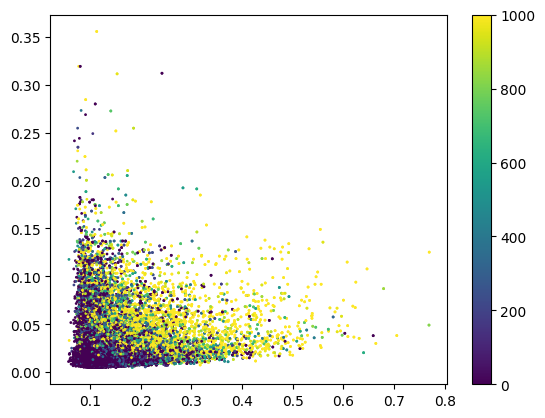

In [14]:
plt.scatter(top10['corr'],top10['minvar'],s=1,c=top10['string'],vmin=0,vmax=1000)
plt.colorbar()

# 50% curve

threshold t=0.1824, precision=0.5020


C:\Users\ki949\AppData\Local\Temp\ipykernel_35892\739249217.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  cs.collections[0].set_label("precision ≈ 0.5")


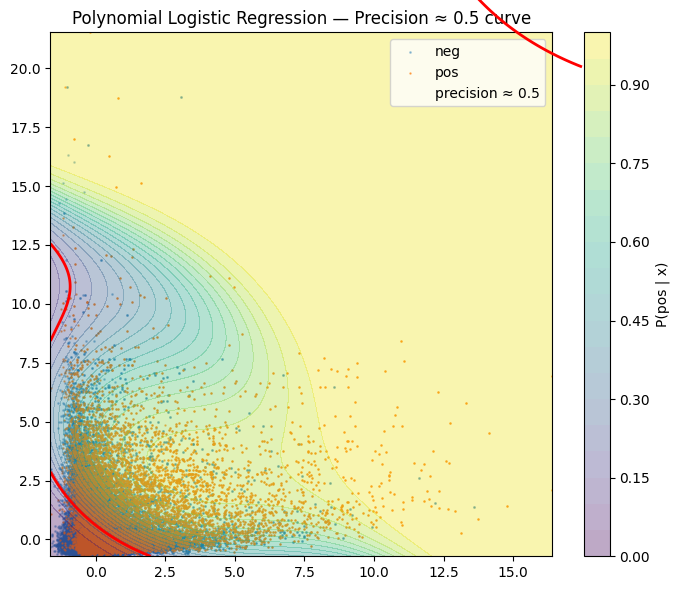

In [61]:
#50% precision curve via polynomial logistic regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# ==============================
# データ
# ==============================
y = (top10["string"] > 400).astype(int).values
X = top10[["corr", "minvar"]].to_numpy()

# ==============================
# 標準化
# ==============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==============================
# 多項式特徴（非線形化）
# ==============================
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

X_pos = X_poly[y==1]
X_neg = X_poly[y==0]

# ==============================
# ロジスティック回帰
# ==============================
clf = LogisticRegression(max_iter=5000)
clf.fit(X_poly, y)

# ==============================
# precision=0.5 の threshold 探索
# ==============================
proba = clf.predict_proba(X_poly)[:,1]

ts = np.linspace(0.01, 0.99, 200)
best_t, best_diff, best_prec = None, 1e9, None

for t in ts:
    pred = (proba >= t).astype(int)
    if pred.sum() == 0:
        continue
    prec = precision_score(y, pred)
    diff = abs(prec - 0.5)
    if diff < best_diff:
        best_diff = diff
        best_t = t
        best_prec = prec

print(f"threshold t={best_t:.4f}, precision={best_prec:.4f}")

# ==============================
# 可視化（元の2D空間で）
# ==============================
xmin, xmax = X_scaled[:,0].min(), X_scaled[:,0].max()
ymin, ymax = X_scaled[:,1].min(), X_scaled[:,1].max()

xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 250),
    np.linspace(ymin, ymax, 250)
)

grid = np.vstack([xx.ravel(), yy.ravel()]).T
grid_poly = poly.transform(grid)

proba_grid = clf.predict_proba(grid_poly)[:,1].reshape(xx.shape)

plt.figure(figsize=(7,6))

plt.scatter(X_scaled[y==0,0], X_scaled[y==0,1], s=1, alpha=0.35, label="neg")
plt.scatter(X_scaled[y==1,0], X_scaled[y==1,1], s=0.5, alpha=0.65, label="pos")

cf = plt.contourf(xx, yy, proba_grid, levels=20, alpha=0.35)
plt.colorbar(cf, label="P(pos | x)")

cs = plt.contour(xx, yy, proba_grid, levels=[best_t], colors="red", linewidths=2)
cs.collections[0].set_label("precision ≈ 0.5")

plt.legend()
plt.title("Polynomial Logistic Regression — Precision ≈ 0.5 curve")
plt.tight_layout()
plt.show()


In [62]:
top10['poly_proba'] = clf.predict_proba(X_poly)[:,1]
top10['accept'] = top10['poly_proba'] >= best_t
top10[top10.accept]


,row,col,corr,string,minvar,poly_proba,accept,row_id,col_id
2,ZNF497,A1BG,0.188498,186,0.010359,0.244846,True,16780,0
5,MZF1,A1BG,0.173135,-1,0.010359,0.182898,True,9256,0
8,SLC27A5,A1BG,0.203527,-1,0.010359,0.306090,True,13293,0
70,SEH1L,AAAS,0.103660,994,0.037159,0.236475,True,12803,7
71,CDCA3,AAAS,0.133916,165,0.037159,0.447904,True,2439,7
...,...,...,...,...,...,...,...,...,...
170864,MYSM1,ZZZ3,0.153412,251,0.018630,0.237056,True,9251,17086
170866,TFDP1,ZZZ3,0.141196,-1,0.027258,0.323749,True,14660,17086
170867,KAT14,ZZZ3,0.253824,996,0.024255,0.711540,True,7248,17086
170868,E2F3,ZZZ3,0.175712,-1,0.027258,0.525565,True,4295,17086


In [63]:
gls_genes = set(top10[top10.accept]['col']) | set(top10[top10.accept]['row'])
print("Number of GLS genes accepted:", len(gls_genes))
gls_genes = sorted(list(gls_genes))
gls_geneids = {gene:i for i,gene in enumerate(gls_genes)}

Number of GLS genes accepted: 5827


In [ ]:
with open("GLS_genes.txt", "w") as f:
    for gene in gls_genes:
        f.write(gene + "\n")
gls_crispr = chronos[gls_genes]
gls_crispr.to_csv("data/GLS_crispr.csv")



In [54]:
gls_crispr_ctr = gls_crispr - gls_crispr.mean()
gls_crispr_ctr.to_csv("data/GLS_crispr_centered.csv")

In [60]:
#Laplacian matrix
top10a = top10[top10.accept].copy()
top10a['row_id'] = top10a['row'].map(gls_geneids)
top10a['col_id'] = top10a['col'].map(gls_geneids)
import numpy as np
gls_weight = np.zeros((len(gls_genes), len(gls_genes)), dtype=np.float32)
for r, c, v in zip(top10a['row_id'], top10a['col_id'], top10a['corr']):
    gls_weight[r, c] = v
    gls_weight[c, r] = v  # symmetric
D = gls_weight.sum(axis=1)
D_diag = np.diag(D)
L = D_diag - gls_weight

import numpy as np
from scipy.io import savemat
savemat('data/gls_laplacian.mat', {'L': L})